**AutoEncoders** are a type of neural network that is mainly designed with the goal of learning low-dimensional representations or **latent features** of a given dataset such that those representations can be used to **reconstruct** the original data.

For such goal, these neural networks are structured as follows:

1. An **encoder network** : This network is used to learn a low-dimensional representation of the input data.

2. A **decoder network** : This network is used to reconstruct the input data from the low-dimensional representation.

3. A **loss function**: This function is used to quantify the difference between the reconstructed data and the original data.

The network then combines the encoder and decoder networks and starts training to minimize the loss function by learning the optimal low-dimensional representation then reconstructing it to the original data.

Once we reach the desired loss and the reconstructed data is close enough to the original data, this would indicate that those low-dimensional representations learned are good enough to represent the original data. We can then say we reached the latent features level of the data.

<br>
<br>

<p align="center">
  <img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-1-4842-8020-1_9/MediaObjects/463356_2_En_9_Fig1_HTML.jpg" />
</p>

# Enabling the GPU

It is advisable to enable GPU as it will speed up the training process considerably compared to CPU.

To Enable the GPU:

> Go to Runtime --> Change runtime type --> Hardware Accelerator --> Select GPU.

Test if GPU is enabled

In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("WARNING: No GPU available!")

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Installations and Imports

Do the necessary installations

In [2]:
!pip install visualkeras  -q
!pip install gdown
!gdown 1tKSnNdRQ8LnRFkcc-LPEV6sI0drwHK-Y
!tar -xvf ArabicMNISTDataset.tar.gz
!rm ArabicMNISTDataset.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.4 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1tKSnNdRQ8LnRFkcc-LPEV6sI0drwHK-Y
To: /content/ArabicMNISTDataset.tar.gz
100% 21.3M/21.3M [00:00<00:00, 78.3MB/s]
ArabicMNISTDataset.mat


Import the necessary libraries.

In [3]:
import keras
from keras import layers
import numpy as np
import pandas as pd
import visualkeras
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Seed the environment
def seed_my_session(seed=16):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
seed_my_session()

# Define some colors for visualizations later
color_map = defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#f58442'
color_map[layers.Conv2D]['fill'] = '#85e079'
color_map[layers.MaxPooling2D]['fill'] = '#d9f2bd'
color_map[layers.Flatten]['fill'] = '#8b848c'
color_map[layers.Dense]['fill'] = '#545354'
color_map[layers.UpSampling2D]['fill'] = '#79c7b1'
color_map[layers.BatchNormalization]['fill'] = '#bc81cc'
color_map[layers.Reshape]['fill'] = '#b4adba'

Create a utility function to display the images to visualize our model's performance later (original VS reconstructed images).

In [9]:
def display_digits(original_images, reconstructed_images, digits=10):
    # Create a figure with 2 rows and columns set to digits for image-vs-image plots
    fig, axes = plt.subplots(2, digits, figsize=(20, 4))
    fig.suptitle('Original Vs Reconstructed Images', fontsize=14, fontweight='bold')
    # Get the axes
    axes = axes.flatten()
    # Display the original and reconstructed images.
    for i in range(digits):
        # Reshape the image from (3600) 1D array to (60,60) 2D array
        original_image = original_images[i].reshape(60, 60)
        # Display original image.
        axes[i].imshow(original_image, cmap='gray')
        axes[i].axis('off')
        # Reshape the image from (3600) 1D array to (60,60) 2D array
        reconstructed_image = reconstructed_images[i].reshape(60, 60)
        # Display reconstructed image below the original one
        axes[i + digits].imshow(reconstructed_image, cmap='gray')
        axes[i + digits].axis('off')
    # Show the figure.
    plt.show()

# Data Preparation

Now Lets Start preparing our Arabic Mnist Dataset

The data was installed as ArabicDataset.mat file



<p align="center">
  <img src="https://raw.githubusercontent.com/mohamadmansourX/AutoEncoders/main/doc/datagrid.png" />
</p>

In [10]:
data_path = 'ArabicMNISTDataset.mat'

# Load the dataset using the data_path
dataset = loadmat(data_path)

# The dataset is stored in a dictionary of train and test data.
x_train = dataset['x_train']
x_test = dataset['x_test']

# Change the dtype of x_train and x_test to float.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# We can check its shape
print(x_train.shape)
print(x_test.shape)

(13439, 3600)
(3359, 3600)


Lets visualize the dataset.


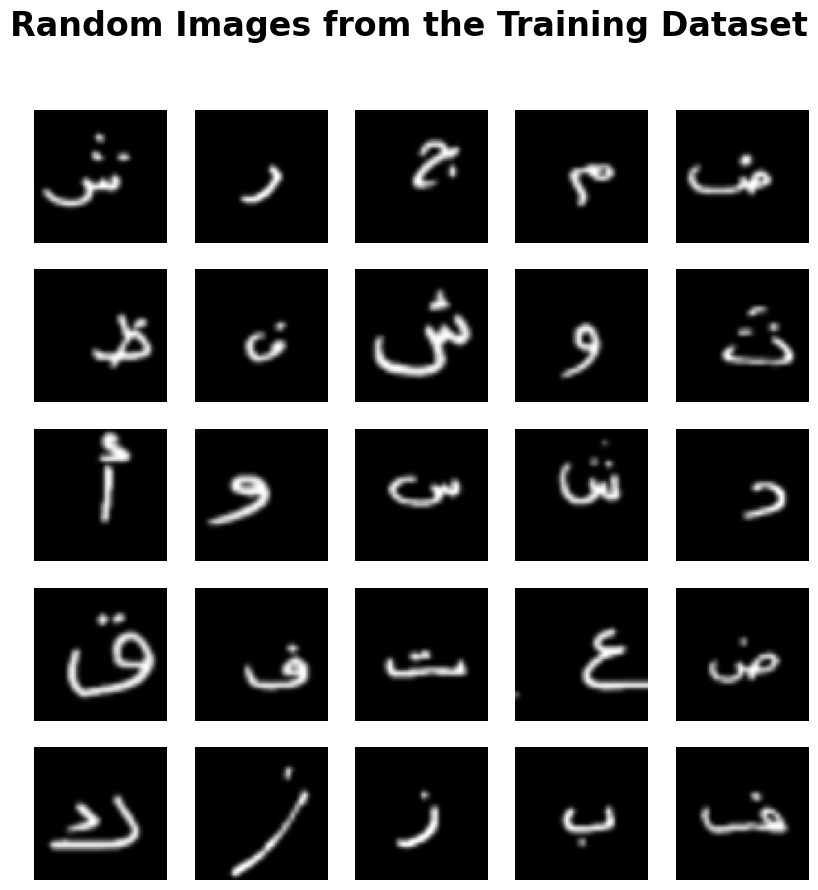

In [11]:
# We will display 5x5 random images from the training dataset
# Get a sample of 25 random images.
sample_images = random.sample(list(x_train), 25)
# Prepare the plot
plt.figure(figsize=(10,10))
# Set a title for the figure.
plt.suptitle('Random Images from the Training Dataset', fontsize=24, fontweight='bold')

for i in range(25):
    # Set the place holder to the current image.
    plt.subplot(5, 5, i+1)
    # Reshape sample_images from 1D (3600) to 2D (60,60)
    sample_image = sample_images[i].reshape(60, 60)
    # Display the current image.
    plt.imshow(sample_image, cmap='gray')
    plt.axis('off')

# Building the AutoEncoder

## Simple ANN AutoEncoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3600)]            0         
                                                                 
 dense (Dense)               (None, 81)                291681    
                                                                 
 batch_normalization (Batch  (None, 81)                324       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 3600)              295200    
                                                                 
Total params: 587205 (2.24 MB)
Trainable params: 587043 (2.24 MB)
Non-trainable params: 162 (648.00 Byte)
_________________________________________________________________


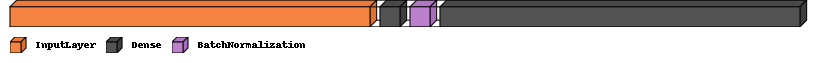

In [12]:
# Building a simple autoencoder

# Set the bottleneck_size to be 81.
bottleneck_size = 81

# Create the input layer having the shape of the training data = 3600
input_layer = keras.layers.Input(shape=(3600,))

# Create the encoder having the neurons set to the bottleneck_size and activate to 'relu'
encoded = keras.layers.Dense(bottleneck_size, activation='relu')(input_layer)

# Let's not forget the Batch Normalization layer.
x = layers.BatchNormalization()(encoded)

# Create the decoder having the output shape equal to the input shape = 3600 and the activation set to 'sigmoid'
decoded = keras.layers.Dense(3600, activation='sigmoid')(x)

# Create the autoencoder.
autoencoder = keras.models.Model(input_layer, decoded)

# Compile the autoencoder using 'adam' as the optimizer and the 'binary_crossentropy' loss.
autoencoder.compile(optimizer='adam' , loss='binary_crossentropy')

# Print the summary of the autoencoder.
autoencoder.summary()

# Visualize the model
visualkeras.layered_view(autoencoder, legend=True,  draw_volume=True, spacing= 10, color_map= color_map)

Note the input data (training data usually denoted by X) and the output data (target data usually denoted by Y) **are the same data** as we are learning to reconstruct the data.

In [13]:
# Fit the autoencoder to the training data by setting epochs to 60 and batch size to 128.
# Both the input and output are the same data
autoencoder.fit(x_train, x_train,
                epochs=60,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/60
105/105 [==============================] - 10s 19ms/step - loss: 0.5560 - val_loss: 0.3526
Epoch 2/60
105/105 [==============================] - 1s 14ms/step - loss: 0.1821 - val_loss: 0.1533
Epoch 3/60
105/105 [==============================] - 1s 8ms/step - loss: 0.1140 - val_loss: 0.1064
Epoch 4/60
105/105 [==============================] - 1s 7ms/step - loss: 0.1006 - val_loss: 0.0960
Epoch 5/60
105/105 [==============================] - 1s 7ms/step - loss: 0.0934 - val_loss: 0.0941
Epoch 6/60
105/105 [==============================] - 1s 8ms/step - loss: 0.0887 - val_loss: 0.0885
Epoch 7/60
105/105 [==============================] - 1s 7ms/step - loss: 0.0856 - val_loss: 0.0847
Epoch 8/60
105/105 [==============================] - 1s 8ms/step - loss: 0.0833 - val_loss: 0.0830
Epoch 9/60
105/105 [==============================] - 1s 10ms/step - loss: 0.0819 - val_loss: 0.0817
Epoch 10/60
105/105 [==============================] - 1s 12ms/step - loss: 0.0803 - val_loss: 0

105/105 [==============================] - 0s 2ms/step


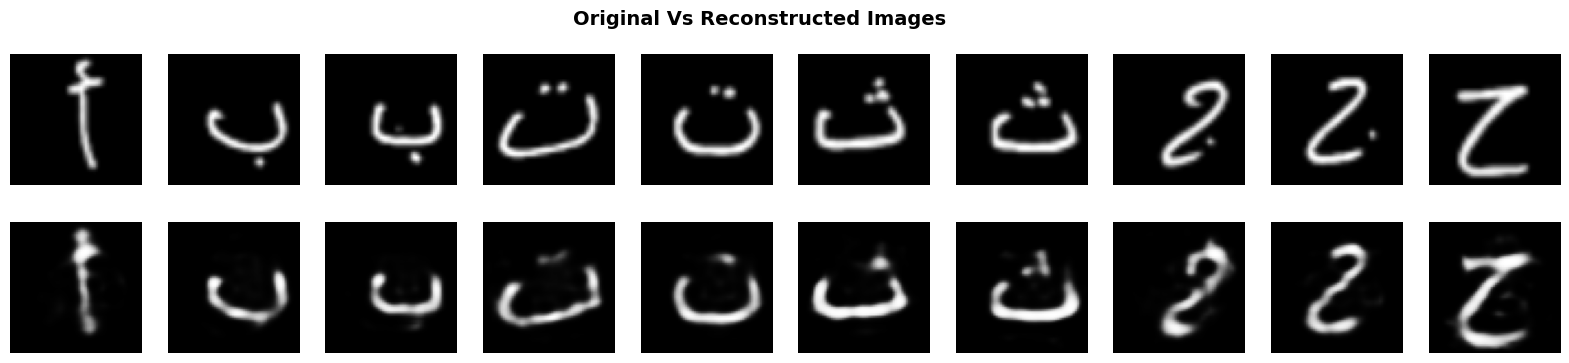

In [14]:
# Generate Restored Images from the x_test using the autoencoder predict function
reconstructed_images = autoencoder.predict(x_test)

# Display Images
display_digits(x_test, reconstructed_images, digits=10)

## Convolutional AutoEncoder

Lets add some convolutions to our networks

First we need to reshape our data to 2D Matrix style

In [15]:
# Change the data from 1D 3600 to a 2D 60x60 shape
x_train_cnn = np.reshape(x_train, (len(x_train), 60, 60, 1))

x_test_cnn = np.reshape(x_test, (len(x_test), 60,60 , 1))

Build the Network

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 40)        400       
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 40)        160       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 40)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 20)        7220      
                                                                 
 batch_normalization_2 (Bat  (None, 30, 30, 20)        80  

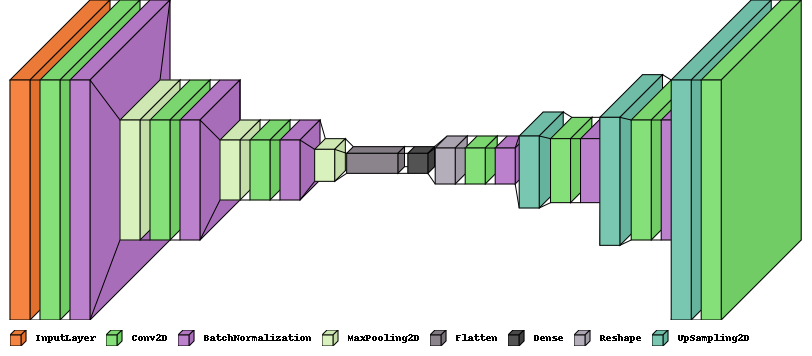

In [16]:
# Set the bottleneck size to be 81.
bottleneck_size = 81

# This is our input image
input_img = keras.Input(shape=(60, 60, 1))

# Define the Encoder
x = layers.Conv2D(40, (3, 3), activation='relu', padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(bottleneck_size)(x)

# Define the decoder
x = layers.BatchNormalization()(x)
x = layers.Reshape((9, 9, 1))(encoded)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(20, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(40, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# The model take the image and feeds it to the 'input_img' layer and then process it and output it from the 'decoded' layer
autoencoder = keras.Model(input_img, decoded)


# Compile the autoencoder using 'adam' as the optimizer and the 'binary_crossentropy' loss.
autoencoder.compile(optimizer='adam' , loss='binary_crossentropy')

# Print the summary of the autoencoder.
autoencoder.summary()

# Visualize the model
visualkeras.layered_view(autoencoder, legend=True,  draw_volume=True, spacing= 10, color_map= color_map)

In [17]:
# Fit the autoencoder to the training data by setting epochs to 60 and batch size to 128.
autoencoder.fit(x_train_cnn, x_train_cnn,
                epochs=60, batch_size=128,
                shuffle=True,
                validation_data=(x_test_cnn, x_test_cnn))

Epoch 1/60
105/105 [==============================] - 12s 45ms/step - loss: 0.4029 - val_loss: 0.2135
Epoch 2/60
105/105 [==============================] - 3s 29ms/step - loss: 0.1131 - val_loss: 0.2324
Epoch 3/60
105/105 [==============================] - 3s 29ms/step - loss: 0.0967 - val_loss: 0.2369
Epoch 4/60
105/105 [==============================] - 3s 28ms/step - loss: 0.0910 - val_loss: 0.2234
Epoch 5/60
105/105 [==============================] - 3s 28ms/step - loss: 0.0872 - val_loss: 0.1928
Epoch 6/60
105/105 [==============================] - 3s 30ms/step - loss: 0.0851 - val_loss: 0.1387
Epoch 7/60
105/105 [==============================] - 3s 28ms/step - loss: 0.0835 - val_loss: 0.0922
Epoch 8/60
105/105 [==============================] - 3s 28ms/step - loss: 0.0823 - val_loss: 0.0836
Epoch 9/60
105/105 [==============================] - 3s 28ms/step - loss: 0.0812 - val_loss: 0.0833
Epoch 10/60
105/105 [==============================] - 3s 30ms/step - loss: 0.0803 - val_l

105/105 [==============================] - 1s 3ms/step


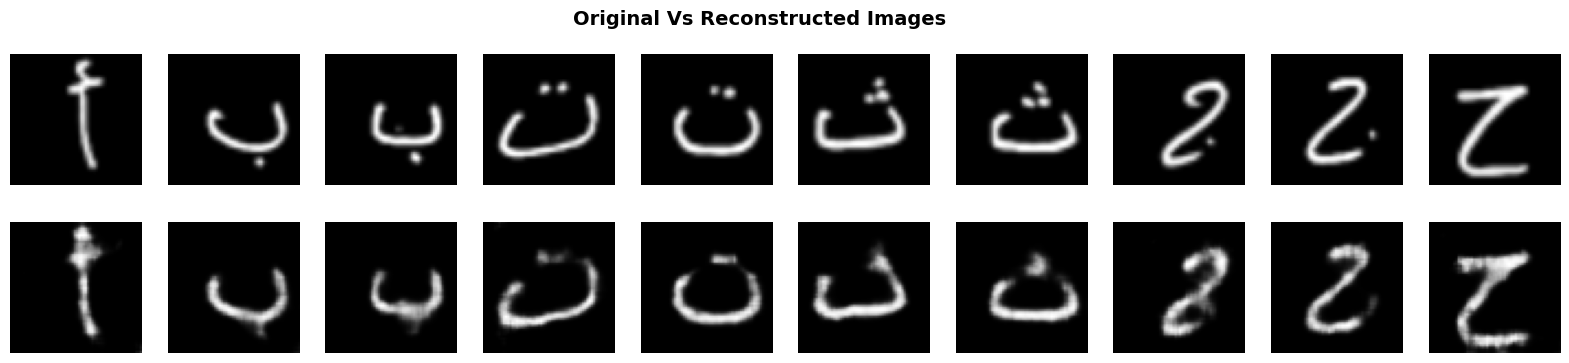

In [18]:
# predict the reconstructed images using the autoencoder predict function and by feeding it with the x_test_cnn
decoded_imgs = autoencoder.predict(x_test_cnn)

# Visualize our results
display_digits(x_test_cnn, decoded_imgs, 10)

## Deeper AutoEncoder

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3600)]            0         
                                                                 
 dense_3 (Dense)             (None, 1000)              3601000   
                                                                 
 batch_normalization_8 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 300)               300300    
                                                                 
 dense_5 (Dense)             (None, 81)                24381     
                                                                 
 dense_6 (Dense)             (None, 300)               24600     
                                                           

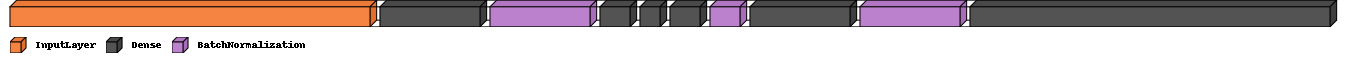

In [19]:
# Lets Create now a deeper Encoder Decoder Networks

# Set the bottleneck size to be 81.
bottleneck_size = 81

# Create the input layer having the shape of the training data input shape = 3600
input_layer = keras.layers.Input(shape=(3600,))

# Define the Encoder
# Hidden activations are 'relu' while last layer activation is 'sigmoid'

# Create the encoder having the first hidden layer with 1000 neurons
x = keras.layers.Dense(1000, activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
# The second hidden layer having 300 neurons
x = keras.layers.Dense(300, activation='relu')(x)
# The third hidden layer having the bottleneck_size
encoded = keras.layers.Dense(bottleneck_size, activation='sigmoid')(x)

# Define the Decoder
# Create the first layer of the decoder having 300 neurons
x = keras.layers.Dense(300, activation='relu')(encoded)
x = layers.BatchNormalization()(x)
# Create the second layer of the decoder having 1000 neurons
x = keras.layers.Dense(1000, activation='relu')(x)
x = layers.BatchNormalization()(x)
# Create the third layer of the decoder having the input shape
decoded = keras.layers.Dense(3600, activation='sigmoid')(x)


# Create the autoencoder.
autoencoder = keras.models.Model(input_layer, decoded)

# Compile the autoencoder using 'adam' as the optimizer and the 'binary_crossentropy' loss.
autoencoder.compile(optimizer='adam' , loss='binary_crossentropy')

# Print the summary of the autoencoder.
autoencoder.summary()

# Visualize the model
visualkeras.layered_view(autoencoder, legend=True,  draw_volume=True, spacing= 10, color_map = color_map)

In [20]:
# Fit the autoencoder to the x_train data and validate using the x_test by setting epochs to 60 and batch size to 128.
autoencoder.fit(x_train, x_train,
                epochs=60, batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/60
105/105 [==============================] - 6s 14ms/step - loss: 0.3647 - val_loss: 0.1438
Epoch 2/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0971 - val_loss: 0.1082
Epoch 3/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0886 - val_loss: 0.1030
Epoch 4/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0842 - val_loss: 0.0933
Epoch 5/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0816 - val_loss: 0.1030
Epoch 6/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0795 - val_loss: 0.0829
Epoch 7/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0776 - val_loss: 0.0795
Epoch 8/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0765 - val_loss: 0.0792
Epoch 9/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0756 - val_loss: 0.0774
Epoch 10/60
105/105 [==============================] - 1s 12ms/step - loss: 0.0748 - val_loss: 0.07

105/105 [==============================] - 0s 3ms/step


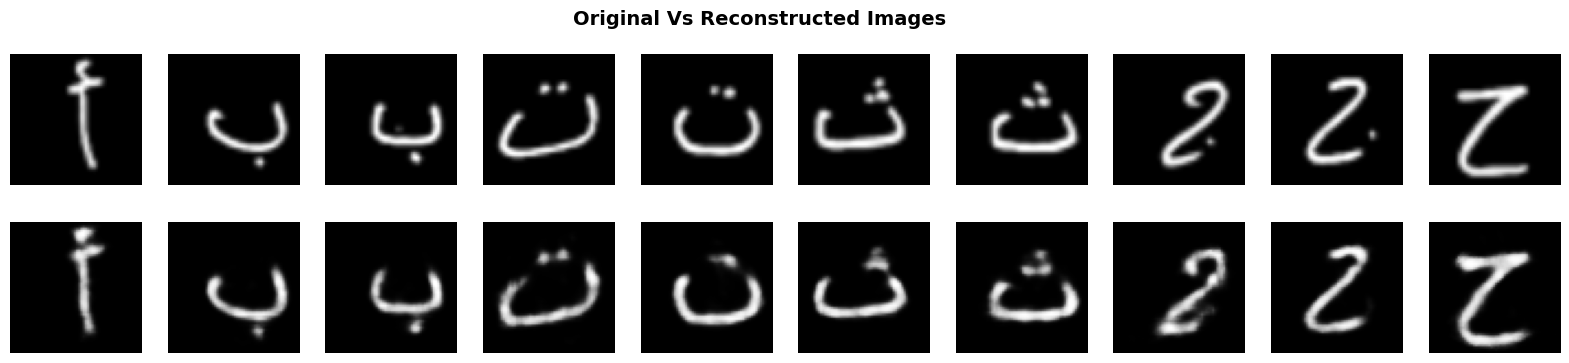

In [21]:
# Generate Restored Images from the x_test using the autoencoder predict function
reconstructed_images = autoencoder.predict(x_test)

# Display digits results, set the digits for the letters you want to visualize e.g. 10
display_digits(x_test, reconstructed_images, digits=10)

# Some Visualizations

Using the above trained model, we'll extract the encoder and decoder

In [22]:
# Define the Encoder Model taking input as the input_layer and output as the encoded layer
encoder_model = keras.Model(input_layer, encoded)

# Define the Decoder Model taking as input the encoded layer and output as the decoded layer
decoder_model = keras.Model(encoded, decoded)

In [23]:
# Let's visualize what happened
# Choose any image from the test test, e.g. index = 9
image = x_test[9]
print("Our image has {} parameters".format(image.shape[0]))

Our image has 3600 parameters


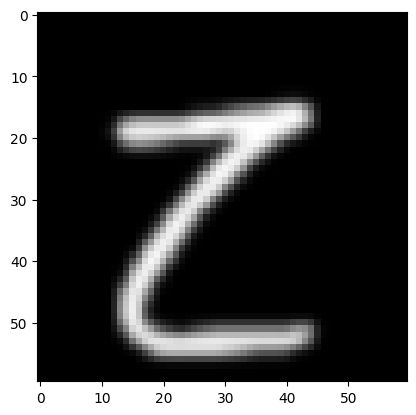

In [24]:
# Reshape to 60x60 and visualize it
plt.imshow(image.reshape(60,60), cmap='gray')

In [25]:
# Encode the image using the encoder_model using the predict function
encoded_image = encoder_model.predict(image.reshape(1, 3600))[0]
print("The encoded representation vector for that image contains now only {} parameters".format(encoded_image.shape[0]))
print("or only {} % of the original data".format(100*encoded_image.shape[0]/image.shape[0]))

1/1 [==============================] - 0s 61ms/step
The encoded representation vector for that image contains now only 81 parameters
or only 2.25 % of the original data


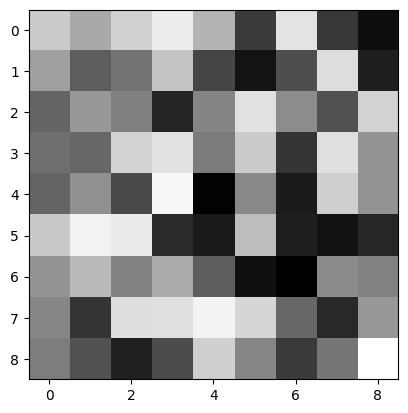

In [26]:
# Let's visualize the encoded_image
# Reshape the 81 vector to 9x9 to better visualize it
plt.imshow(encoded_image.reshape(9,9), cmap='gray')

1/1 [==============================] - 0s 82ms/step


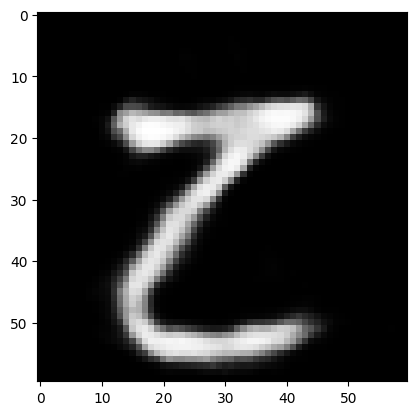

In [27]:
# Now Using only the 9x9 vector let's try reconstructing the image

decoded_image = decoder_model.predict(encoded_image.reshape(1, 81))[0]

# Reshape to 60x60 and visualize it
plt.imshow(decoded_image.reshape(60,60), cmap='gray')

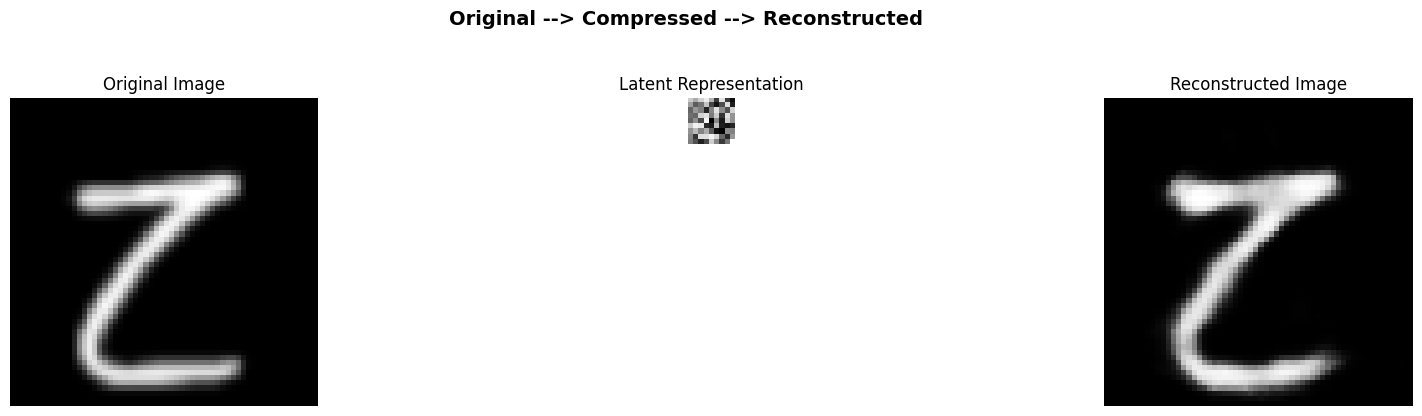

In [28]:
# On a more scaled Plots for better visualizations with scale

fig, axes = plt.subplots(1, 3, figsize=(20, 4),sharex=False, sharey=True)
fig.suptitle('Original --> Compressed --> Reconstructed', fontsize=14, fontweight='bold', y=1.1)

axes = axes.flatten()
# Display original image.
axes[0].imshow(image.reshape(60,60), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')
# Display latent representation of the image.
axes[1].imshow(encoded_image.reshape(9,9), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Latent Representation')
# Display the reconstructed image
axes[2].imshow(decoded_image.reshape(60,60), cmap='gray')
axes[2].axis('off')
axes[2].set_title('Reconstructed Image')
plt.show()

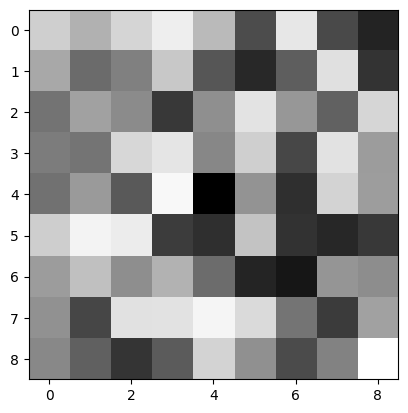

In [29]:
# Let's try playing with some pixels in the encoded image
encoded_image_pixel_changed = encoded_image.copy()

# Reshape the vector to 9x9
encoded_image_pixel_changed = encoded_image_pixel_changed.reshape(9,9)

# From the above 9x9 encoded image - latent Representation - choose any pixel that appears to be white colored ==> high value and let's try setting it to 0
# Fill in the xy coordinates of that image using the previous encoded_image plot and set its value to 0
encoded_image_pixel_changed[4][4] = 0

# Reshape the 81 vector to 9x9 to better visualize it
plt.imshow(encoded_image_pixel_changed.reshape(9,9), cmap='gray')

1/1 [==============================] - 0s 19ms/step


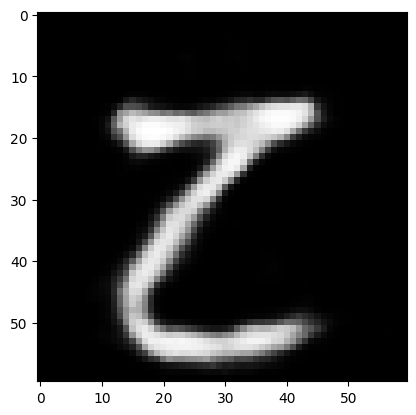

In [30]:
# Now Using only the edited 9x9 vector let's reconstruct the decoded image using the decoder_model

decoded_image = decoder_model.predict(encoded_image_pixel_changed.reshape(1, 81))[0]

plt.imshow(decoded_image.reshape(60,60), cmap='gray')

# An Application on AutoEncoder

## Feature Extractor

Let's Try making use of the power of autoencoder in learning latent representations to build a classifer

In [31]:
# Load our dataset labels
y_train = dataset['y_train'][0]
y_test = dataset['y_test'][0]
labels = ['٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']
y_test.shape, y_test.shape

((3359,), (3359,))

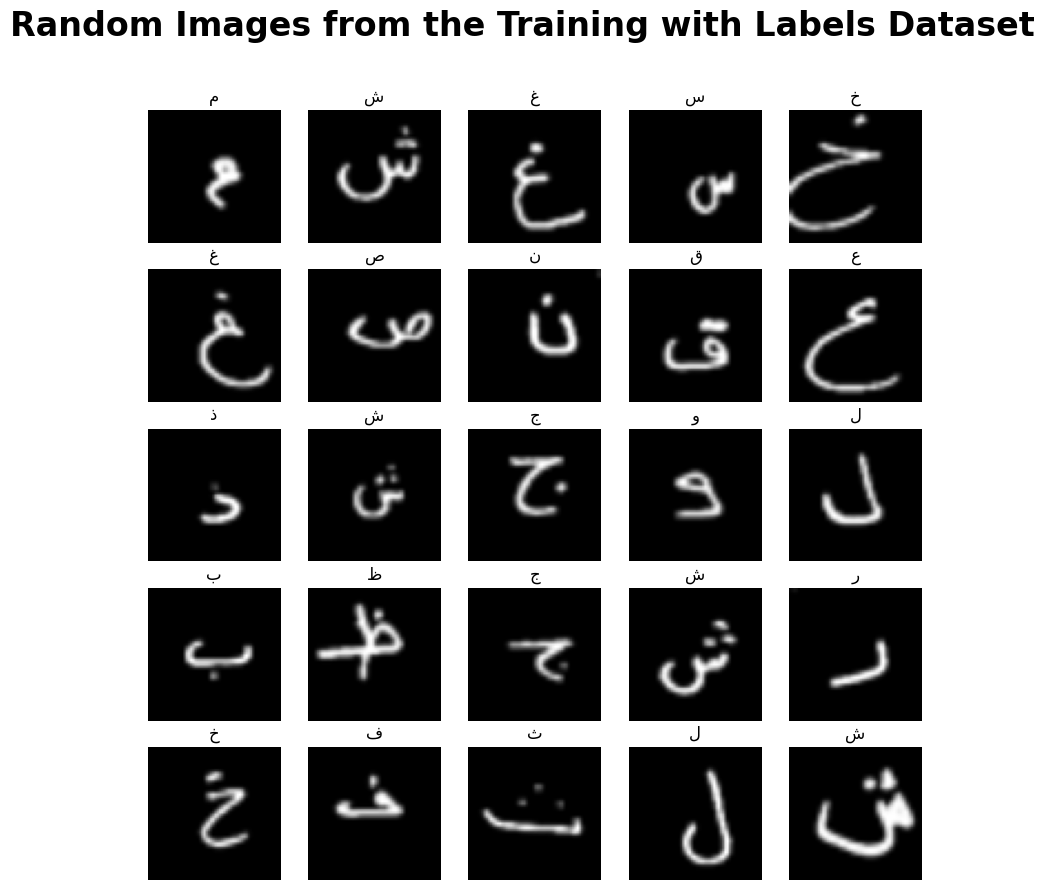

In [32]:
# Let's visualize the dataset of images with their corresponding labels
# Get a sample of 25 random images from the training noisy dataset.
indexes = random.sample(range(len(x_train)), 25)

sample_images = x_train[indexes]
sample_targets = y_train[indexes]
# Display the images.
plt.figure(figsize=(10,10))
# Set a title for the figure.
plt.suptitle('Random Images from the Training with Labels Dataset', fontsize=24, fontweight='bold')

for i in range(25):
    # Set the place holder to the current image.
    plt.subplot(5, 5, i+1)
    # Display the current image.
    plt.title(labels[sample_targets[i]])
    plt.imshow(sample_images[i].reshape(60, 60), cmap='gray')
    plt.axis('off')

Now we'll try training a classifier using only the latent representations learned from our encoder in the Deeper AutoEncoder task inorder to classify our letters

In [33]:
# Output neurons are set to the length of labels list
output_neurons = len(labels)

# Define our input layer having 3600 as input
input_img = keras.Input(shape=(3600,))

# Use the encoder_model to encode the input_image
encoded_img = encoder_model(input_img)

# Set the encoder_model as nontrainable, we're not interested in training them anymore. We are taking only the learned latent representation
# Set the trainable parameter of encoder_model to False
encoder_model.trainable= False

# Create BatchNormalization layer
x = layers.BatchNormalization()(encoded_img)

# Create first dense layer with 512 neurons and a relu activation function
x = layers.Dense(512, activation='relu')(x)

# Create BatchNormalization layer
x = layers.BatchNormalization()(x)

# Create our output layer having output neurons equal to the output_neurons parameter and the suitable activation function for our multiclass classification task
classifier_output = layers.Dense(output_neurons, activation='softmax')(x)

# Create the classifier taken input_image as first layer and classifier_output as output layer
classifier_model = keras.models.Model(input_img, classifier_output)

# Print our model summary
classifier_model.summary()

# Compile the clasisifer using 'sparse_categorical_crossentropy' as a loss function, 'accuracy' as a metric and the same optimizer as in above examples
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3600)]            0         
                                                                 
 model_3 (Functional)        (None, 81)                3929681   
                                                                 
 batch_normalization_11 (Ba  (None, 81)                324       
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 512)               41984     
                                                                 
 batch_normalization_12 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 38)                1949

In [34]:
# Fit the classifier_model to the training data (x_train, y_train) while validating using (x_test, y_test) and by setting epochs to 30 and batch size to 128.
classifier_model.fit(x_train, y_train,
                epochs=30, batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/30
105/105 [==============================] - 3s 9ms/step - loss: 2.2459 - accuracy: 0.3825 - val_loss: 2.9427 - val_accuracy: 0.3194
Epoch 2/30
105/105 [==============================] - 1s 6ms/step - loss: 1.3111 - accuracy: 0.6103 - val_loss: 2.0942 - val_accuracy: 0.5201
Epoch 3/30
105/105 [==============================] - 1s 6ms/step - loss: 0.9966 - accuracy: 0.7046 - val_loss: 1.3757 - val_accuracy: 0.6359
Epoch 4/30
105/105 [==============================] - 1s 6ms/step - loss: 0.7922 - accuracy: 0.7707 - val_loss: 1.0258 - val_accuracy: 0.6910
Epoch 5/30
105/105 [==============================] - 1s 6ms/step - loss: 0.6491 - accuracy: 0.8193 - val_loss: 0.8916 - val_accuracy: 0.7252
Epoch 6/30
105/105 [==============================] - 1s 6ms/step - loss: 0.5370 - accuracy: 0.8509 - val_loss: 0.8228 - val_accuracy: 0.7330
Epoch 7/30
105/105 [==============================] - 1s 6ms/step - loss: 0.4530 - accuracy: 0.8776 - val_loss: 0.7837 - val_accuracy: 0.7428
Epoch 

1/1 [==============================] - 0s 17ms/step


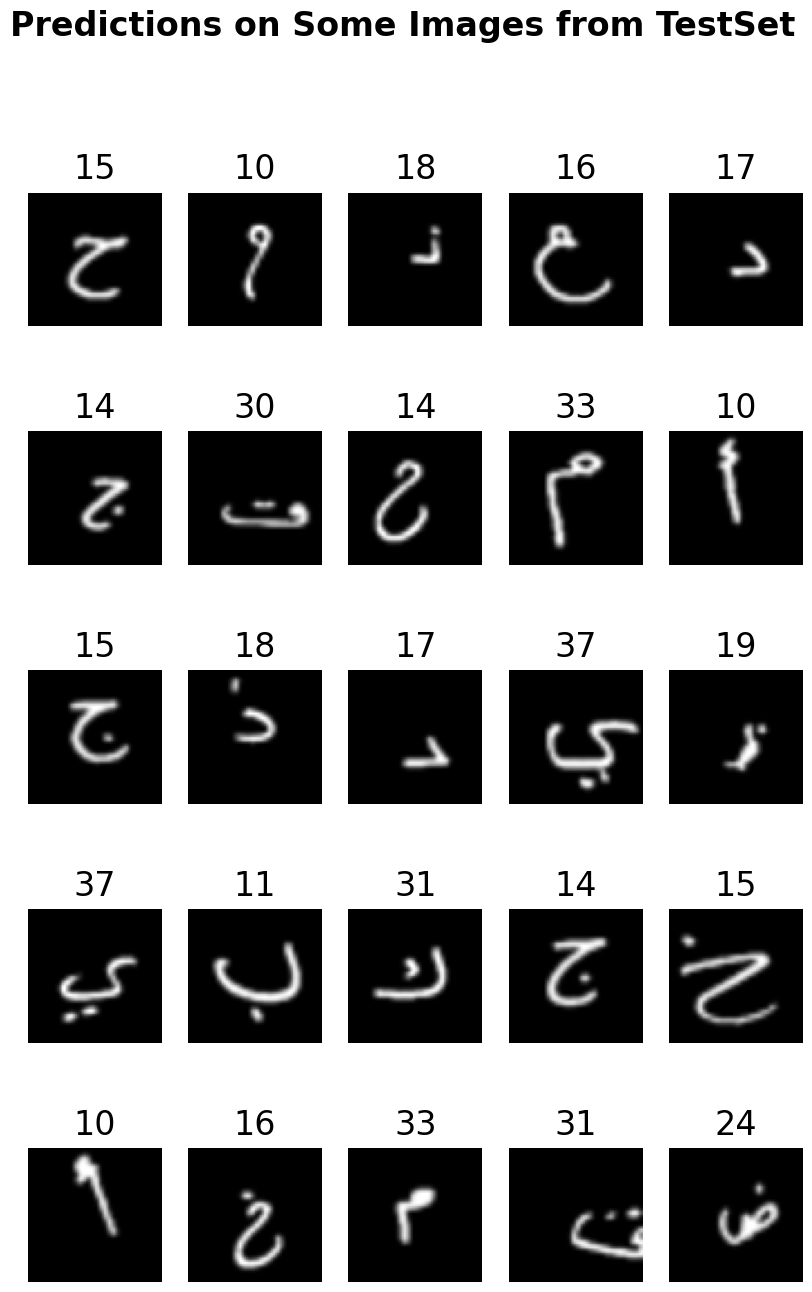

In [35]:
# Let's visualize some predictions
# Get a sample of 25 random images from the training dataset.
indexes = random.sample(range(len(x_test)), 25)

sample_images = x_test[indexes]
# Display the images.
plt.figure(figsize=(10,15))
# Set a title for the figure.
plt.suptitle('Predictions on Some Images from TestSet', fontsize=24, fontweight='bold')

for i in range(25):
    # Set the place holder to the current image.
    plt.subplot(5, 5, i+1)
    # Reshape the sample_image to (1,3600) to be fed to our model
    sample_image = sample_images[i].reshape(1,3600)
    # Get the predictions of the sample_image using our classifier_model predict function
    predicted_labels_weights = classifier_model.predict(sample_image)
    # Get the highest weighted predicted label using the argmax() function
    predicted_label = predicted_labels_weights.argmax()
    # Get the predicted character from the predicted_label using our labels list
    character_label = labels[predicted_label]
    # Display the title as our predicted label
    plt.title(predicted_label, fontdict={'fontsize':24}, pad=10)
    # Display the current image and reshpae to 60x60
    plt.imshow(sample_images[i].reshape(60, 60), cmap='gray')
    plt.axis('off')

## Noise Filtering

In [36]:
# Create some noise for the training data
train_noise = np.random.normal(0, 0.1, x_train.shape)

# Create some noise for the testing data
test_noise = np.random.normal(0, 0.1, x_test.shape)

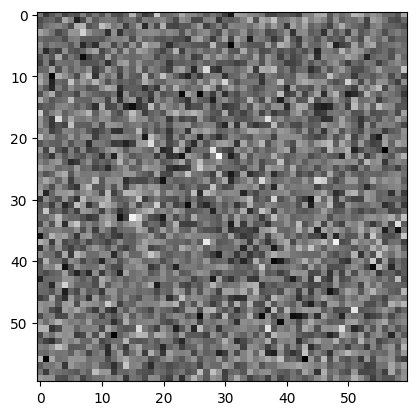

In [37]:
# Visualize one of the noise filters that we'll add to our training dataset
plt.imshow(train_noise[0].reshape(60,60), cmap='gray')

In [38]:
# Add the noise filters to our training and testing datasets
x_train_noisy =  x_train + train_noise
x_test_noisy  =  x_test + test_noise

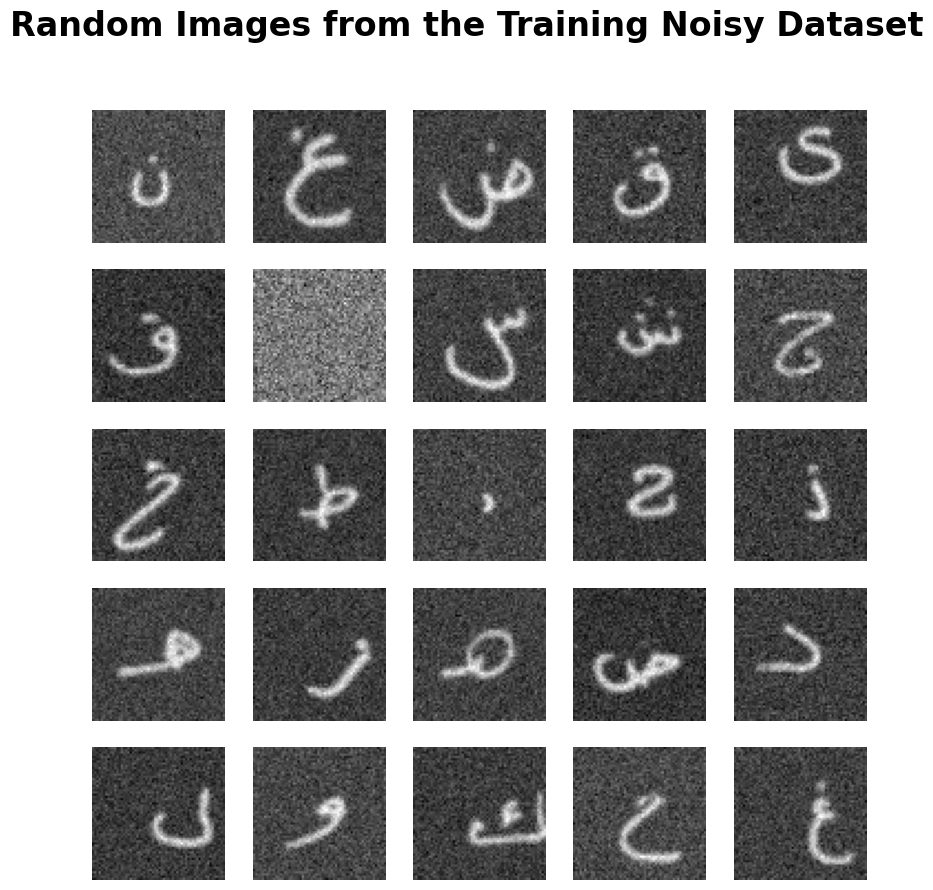

In [39]:
# Let's visualize the noisy dataset
# Get a sample of 25 random images from the training noisy dataset.
sample_images = random.sample(list(x_train_noisy), 25)
# Display the images.
plt.figure(figsize=(10,10))
# Set a title for the figure.
plt.suptitle('Random Images from the Training Noisy Dataset', fontsize=24, fontweight='bold')

for i in range(25):
    # Set the place holder to the current image.
    plt.subplot(5, 5, i+1)
    # Display the current image.
    plt.imshow(sample_images[i].reshape(60, 60), cmap='gray')
    plt.axis('off')


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3600)]            0         
                                                                 
 dense_11 (Dense)            (None, 1000)              3601000   
                                                                 
 batch_normalization_13 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 300)               300300    
                                                                 
 dense_13 (Dense)            (None, 81)                24381     
                                                                 
 dense_14 (Dense)            (None, 300)               24600     
                                                           

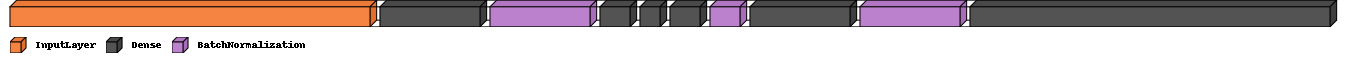

In [40]:
# Lets Create now a deeper Encoder Decoder Networks

# Set the bottleneck size to be 81.
bottleneck_size = 81

# Create the input layer having the shape of the training data input shape = 3600
input_layer = keras.layers.Input(shape=(3600,))

# Create the encoder having the first hidden layer with 1000 neurons and actuvation to relu
x = keras.layers.Dense(1000, activation='relu')(input_layer)
# Add a BacthNormalization layer
x = keras.layers.BatchNormalization()(x)
# The second hidden layer having 300 neurons
x = keras.layers.Dense(300, activation='relu')(x)

# The third hidden layer having the bottleneck_size
encoded = keras.layers.Dense(bottleneck_size, activation='sigmoid')(x)

# Create the first layer of the decoder having 300 neurons
x = keras.layers.Dense(300, activation='relu')(encoded)
# Add BatchNormalization layer
x = keras.layers.BatchNormalization()(x)
# Create the second layer of the decoder having 1000 neurons
x = keras.layers.Dense(1000, activation='relu')(x)
# Add BatchNormalization layer
x = keras.layers.BatchNormalization()(x)
# Create the third layer of the decoder having the input shape
decoded = keras.layers.Dense(3600, activation='sigmoid')(x)


# Create the autoencoder.
autoencoder = keras.models.Model(input_layer, decoded)

# Compile the autoencoder using 'adam' as the optimizer and the 'binary_crossentropy' loss.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print the summary of the autoencoder.
autoencoder.summary()

# Visualize the model
visualkeras.layered_view(autoencoder, legend=True,  draw_volume=True, spacing= 10, color_map = color_map)

In [41]:
# Fit the autoencoder to the training data where our input is now the noise one (x_train_noisy)
# and the output we are trying to learn is the clean one (x_train)
# The same gos for the validation
# Set epochs to 60 and batch size to 128.

autoencoder.fit(x_train_noisy, x_train,
                epochs=60, batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/60
105/105 [==============================] - 4s 14ms/step - loss: 0.3603 - val_loss: 0.1407
Epoch 2/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0962 - val_loss: 0.1063
Epoch 3/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0878 - val_loss: 0.0895
Epoch 4/60
105/105 [==============================] - 1s 12ms/step - loss: 0.0836 - val_loss: 0.0865
Epoch 5/60
105/105 [==============================] - 1s 12ms/step - loss: 0.0811 - val_loss: 0.0848
Epoch 6/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0792 - val_loss: 0.0810
Epoch 7/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0776 - val_loss: 0.0799
Epoch 8/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0764 - val_loss: 0.0786
Epoch 9/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0753 - val_loss: 0.0786
Epoch 10/60
105/105 [==============================] - 1s 9ms/step - loss: 0.0743 - val_loss: 0.0

Let's visualize how the autoencoder is doing at cleaning the noise from the letters

105/105 [==============================] - 0s 2ms/step


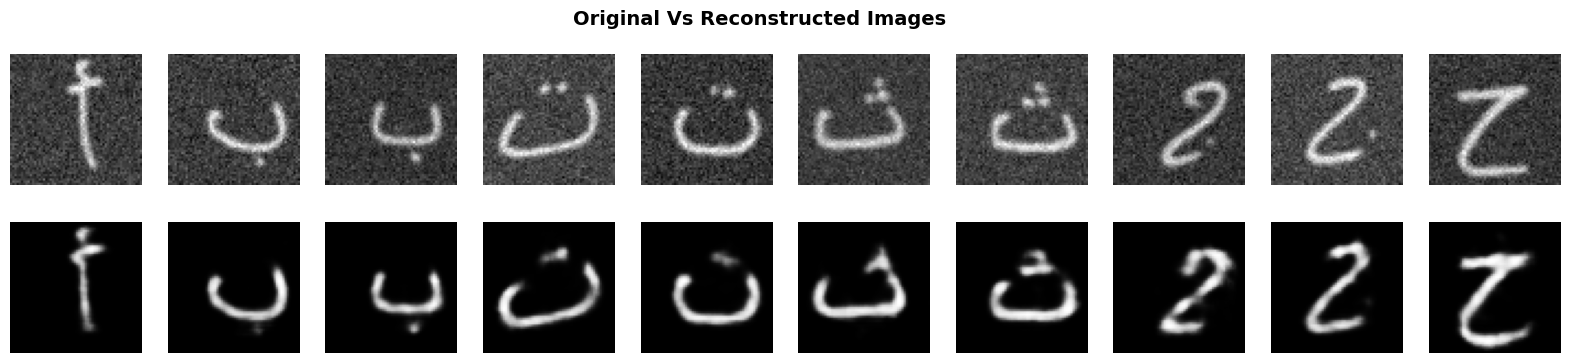

In [42]:
# Generate Restored Images from the x_test_noisy using the autoencoder predict function
reconstructed_images = autoencoder.predict(x_test_noisy)

# Display Images
display_digits(x_test_noisy, reconstructed_images, digits=10)